In [22]:
import librosa 
import librosa.display
import numpy as np
import pandas as pd
from pathlib import Path
import seaborn as sns
from tensorflow import keras 
from tensorflow.keras.preprocessing import image_dataset_from_directory, image 
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.applications import VGG19, ResNet50
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, GlobalAveragePooling2D, InputLayer, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator


In [2]:
path = Path.cwd()/'data'
answers = pd.read_csv('answers.csv')

In [30]:
def import_data():
    datagen = ImageDataGenerator()
    new_path=Path.cwd()/'data_split'
    images_directory = new_path
    cb_training = datagen.flow_from_directory(images_directory/'training', class_mode='binary', target_size=(97,97))
    cb_validation = datagen.flow_from_directory(images_directory/'validation', class_mode='binary',  target_size=(97,97))
    return (cb_training, cb_validation)



def base_set_up(filename, patience=2):
    
    xx =compute_class_weight(class_weight='balanced',classes=np.unique(answers.label), y=answers.label)
    class_weight = dict(zip(np.unique(answers.label), xx))
    METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
    ]

    earlystop = EarlyStopping(monitor='val_loss',verbose=1, patience=patience)
    checkpoint = ModelCheckpoint(filename, monitor='val_loss', save_best_only=True, save_weights_only=False, verbose=1)
    return (class_weight, METRICS, earlystop, checkpoint)

# Continue Training Resnet50 w/ cb validation 

In [7]:
# Early stopping 

# model = None
# keras.backend.clear_session()

filename = 'resnet-cb.h5'
cb_training, cb_validation  = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename,patience=3)

# base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(97,97,3))
# for layer in base_model.layers:
#     layer.trainable = False

# x = base_model.output
# x = Flatten()(x)

# x = Dense(500, activation='relu')(x)
# x = Dropout(.5)(x)
# x = Dense(500, activation='relu')(x)
# x = Dropout(.5)(x)


# predictions = Dense(1, activation='sigmoid')(x)
# optimizer = Adam(learning_rate=0.00001)

# # model =  Model(inputs=base_model.input, outputs=predictions)
# # model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=METRICS)


model = load_model(filename)
history = model.fit(cb_training, epochs=10,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
Epoch 1/10


2022-03-22 16:12:36.399320: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


750/750 [==============================] - 644s 853ms/step - loss: 0.2445 - tp: 5225.0000 - fp: 2453.0000 - tn: 15919.0000 - fn: 403.0000 - accuracy: 0.8810 - precision: 0.6805 - recall: 0.9284 - auc: 0.9612 - prc: 0.8759 - val_loss: 0.2621 - val_tp: 1259.0000 - val_fp: 564.0000 - val_tn: 4037.0000 - val_fn: 140.0000 - val_accuracy: 0.8827 - val_precision: 0.6906 - val_recall: 0.8999 - val_auc: 0.9556 - val_prc: 0.8623

Epoch 00001: val_accuracy improved from -inf to 0.88267, saving model to resnet-cb.h5


/opt/anaconda3/envs/metis/lib/python3.8/site-packages/tensorflow/python/keras/utils/generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


Epoch 2/10
750/750 [==============================] - 553s 737ms/step - loss: 0.2388 - tp: 5195.0000 - fp: 2349.0000 - tn: 16023.0000 - fn: 433.0000 - accuracy: 0.8841 - precision: 0.6886 - recall: 0.9231 - auc: 0.9633 - prc: 0.8822 - val_loss: 0.2453 - val_tp: 1229.0000 - val_fp: 480.0000 - val_tn: 4121.0000 - val_fn: 170.0000 - val_accuracy: 0.8917 - val_precision: 0.7191 - val_recall: 0.8785 - val_auc: 0.9552 - val_prc: 0.8609

Epoch 00002: val_accuracy improved from 0.88267 to 0.89167, saving model to resnet-cb.h5
Epoch 3/10
750/750 [==============================] - 474s 632ms/step - loss: 0.2265 - tp: 5245.0000 - fp: 2248.0000 - tn: 16124.0000 - fn: 383.0000 - accuracy: 0.8904 - precision: 0.7000 - recall: 0.9319 - auc: 0.9667 - prc: 0.8950 - val_loss: 0.2353 - val_tp: 1162.0000 - val_fp: 385.0000 - val_tn: 4216.0000 - val_fn: 237.0000 - val_accuracy: 0.8963 - val_precision: 0.7511 - val_recall: 0.8306 - val_auc: 0.9546 - val_prc: 0.8623

Epoch 00003: val_accuracy improved from 0

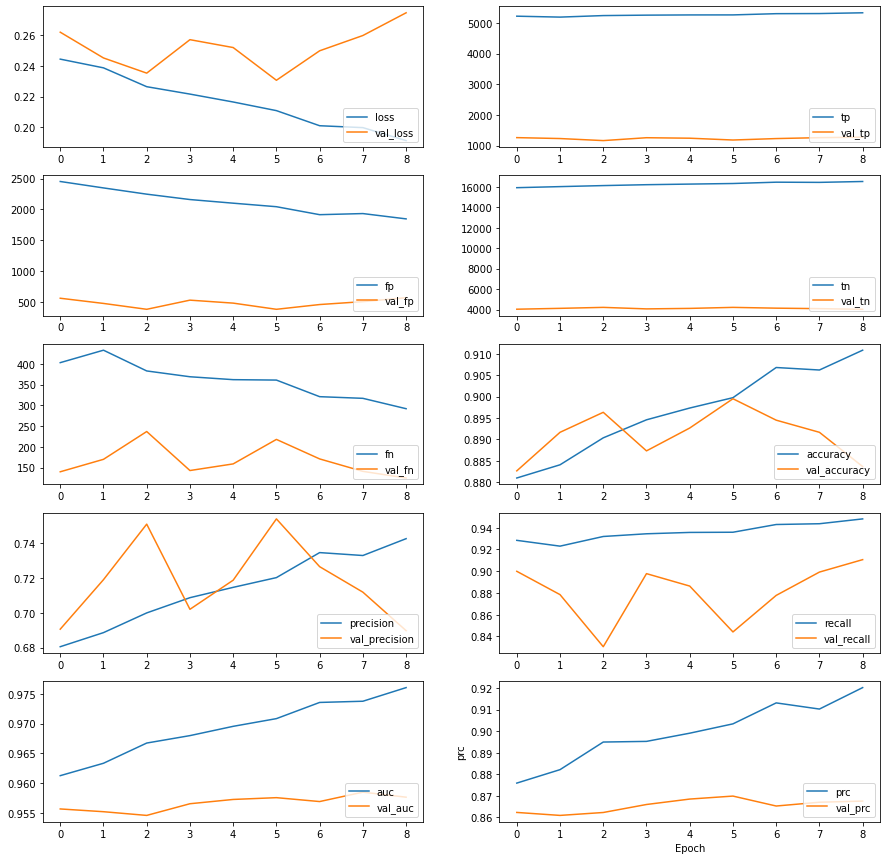

In [9]:
hist = history.history
all_keys = list(hist.keys())

fig, axes = plt.subplots(5,2, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
        key = all_keys[i]
        val_key = 'val_'+key
        ax.plot(hist[key], label=key)
        ax.plot(hist[val_key], label = val_key)
        plt.xlabel('Epoch')
        plt.ylabel(key)
        ax.legend(loc='lower right')

# Analysis 
This is a continuation of training from notebook 9.5.   
we ended notebook 9.5 on 10 epochs, with a val accuracy of .89 and val recall of .86. 
```
Epoch 10/10
750/750 [==============================] - 638s 851ms/step - loss: 0.2534 - tp: 5182.0000 - fp: 2469.0000 - tn: 15903.0000 - fn: 446.0000 - accuracy: 0.8785 - precision: 0.6773 - recall: 0.9208 - auc: 0.9587 - prc: 0.8687 - val_loss: 0.2461 - val_tp: 1215.0000 - val_fp: 475.0000 - val_tn: 4126.0000 - val_fn: 184.0000 - val_accuracy: 0.8902 - val_precision: 0.7189 - val_recall: 0.8685 - val_auc: 0.9538 - val_prc: 0.8607
```
                                                                                
Continuing from there, there appear to be no significant improvements after that. The val accuracy has started dropping - and early stopping kicked in on epoch 9, with a patience of 3. 


# Lets Try a Smaller Dropout and 3 smaller layers instead of 2. If we see an improvement, we'll keep digging in this direction. 

In [12]:
# Early stopping 

model = None
keras.backend.clear_session()

filename = 'resnet-cb-3-dropout-1.h5'
cb_training, cb_validation  = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename,patience=3)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(97,97,3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = Dropout(.1)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(.1)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(.1)(x)


predictions = Dense(1, activation='sigmoid')(x)
optimizer = Adam(learning_rate=0.00001)

model =  Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=METRICS)

history = model.fit(cb_training, epochs=40,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])

Found 30000 files belonging to 2 classes.
Using 24000 files for training.
Found 30000 files belonging to 2 classes.
Using 6000 files for validation.
Epoch 1/40
750/750 [==============================] - 685s 897ms/step - loss: 0.4222 - tp: 4766.0000 - fp: 4303.0000 - tn: 14069.0000 - fn: 862.0000 - accuracy: 0.7848 - precision: 0.5255 - recall: 0.8468 - auc: 0.8832 - prc: 0.6803 - val_loss: 0.3491 - val_tp: 1266.0000 - val_fp: 842.0000 - val_tn: 3759.0000 - val_fn: 133.0000 - val_accuracy: 0.8375 - val_precision: 0.6006 - val_recall: 0.9049 - val_auc: 0.9292 - val_prc: 0.7877

Epoch 00001: val_loss improved from inf to 0.34912, saving model to resnet-cb-3-dropout-1.h5
Epoch 2/40
750/750 [==============================] - 629s 839ms/step - loss: 0.3400 - tp: 5000.0000 - fp: 3458.0000 - tn: 14914.0000 - fn: 628.0000 - accuracy: 0.8298 - precision: 0.5912 - recall: 0.8884 - auc: 0.9258 - prc: 0.7805 - val_loss: 0.2918 - val_tp: 1226.0000 - val_fp: 661.0000 - val_tn: 3940.0000 - val_fn: 17

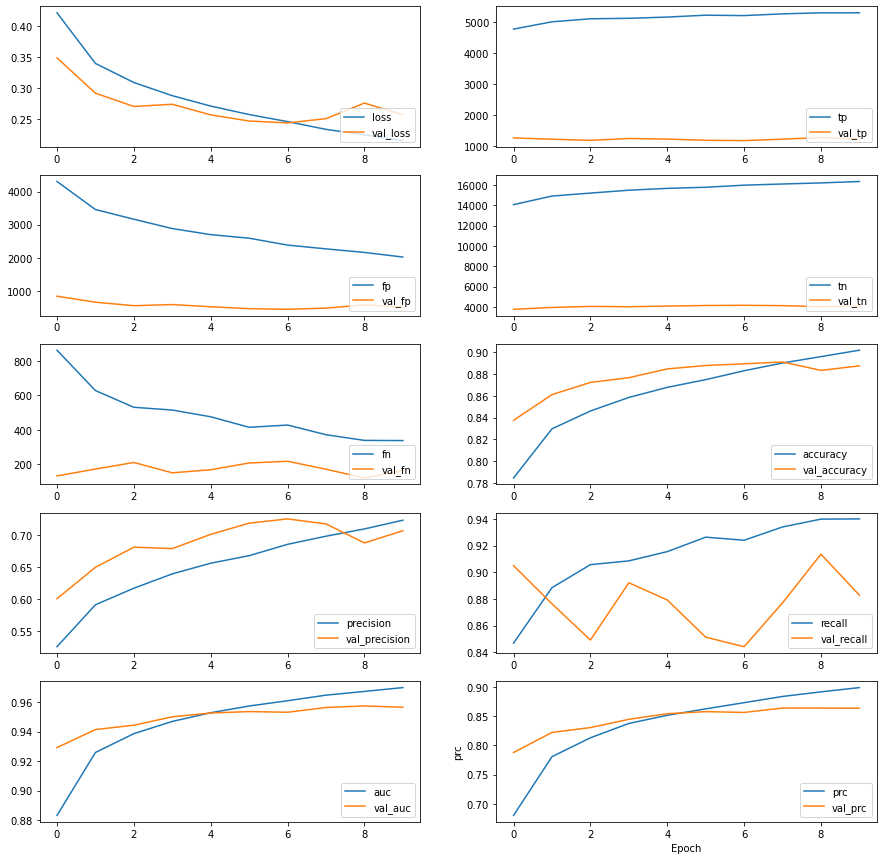

In [13]:
hist = history.history
all_keys = list(hist.keys())

fig, axes = plt.subplots(5,2, figsize=(15,15))
for i,ax in enumerate(axes.flatten()):
        key = all_keys[i]
        val_key = 'val_'+key
        ax.plot(hist[key], label=key)
        ax.plot(hist[val_key], label = val_key)
        plt.xlabel('Epoch')
        plt.ylabel(key)
        ax.legend(loc='lower right')

In [16]:
cb_training, cb_validation  = import_data()

model.evaluate(cb_validation, verbose=1)

Found 29195 files belonging to 2 classes.
Using 23356 files for training.
Found 29195 files belonging to 2 classes.
Using 5839 files for validation.
183/183 [==============================] - 114s 621ms/step - loss: 0.2360 - tp: 1151.0000 - fp: 513.0000 - tn: 4094.0000 - fn: 81.0000 - accuracy: 0.8983 - precision: 0.6917 - recall: 0.9343 - auc: 0.9672 - prc: 0.8736


[0.23602429032325745,
 1151.0,
 513.0,
 4094.0,
 81.0,
 0.8982702493667603,
 0.6917067170143127,
 0.9342532753944397,
 0.9671897292137146,
 0.8736092448234558]

# Analysis 
Early stopping kicked in, when no improvements in loss for 3 epochs. 
We're not gettign anywhere near 40 epochs. 

Since we're maxing out the accuracy a little below .9 for valuation - not bad 

In [18]:
model2 = load_model(filename)
cb_training, cb_validation  = import_data()
model2.evaluate(cb_training, verbose=1)
model2.evaluate(cb_validation, verbose=1)

Found 29195 files belonging to 2 classes.
Using 23356 files for training.
Found 29195 files belonging to 2 classes.
Using 5839 files for validation.
183/183 [==============================] - 120s 656ms/step - loss: 0.2236 - tp: 1085.0000 - fp: 448.0000 - tn: 4159.0000 - fn: 147.0000 - accuracy: 0.8981 - precision: 0.7078 - recall: 0.8807 - auc: 0.9615 - prc: 0.8590


[0.22363561391830444,
 1085.0,
 448.0,
 4159.0,
 147.0,
 0.8980990052223206,
 0.7077625393867493,
 0.8806818127632141,
 0.961473822593689,
 0.8590459823608398]

In [ ]:
model = None
keras.backend.clear_session()

filename = 'resnet-2-layer-1-dropout.h5'
cb_training, cb_validation  = import_data()
class_weight, METRICS, earlystop, checkpoint = base_set_up(filename,patience=10)

base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(97,97,3))
for layer in base_model.layers:
    layer.trainable = False

x = base_model.output
x = Flatten()(x)

x = Dense(100, activation='relu')(x)
x = Dropout(.1)(x)
x = Dense(100, activation='relu')(x)
x = Dropout(.1)(x)
predictions = Dense(1, activation='sigmoid')(x)
optimizer = Adam(learning_rate=0.00001)

model =  Model(inputs=base_model.input, outputs=predictions)
model.compile(optimizer=optimizer,loss='binary_crossentropy', metrics=METRICS)

history = model.fit(cb_training, epochs=40,validation_data=cb_validation, class_weight = class_weight, callbacks=[earlystop, checkpoint])


Found 23194 images belonging to 2 classes.
Found 3047 images belonging to 2 classes.
Epoch 1/40
352/725 [=============>................] - ETA: 4:17 - loss: 0.4620 - tp: 1827.0000 - fp: 2224.0000 - tn: 6682.0000 - fn: 525.0000 - accuracy: 0.7558 - precision: 0.4510 - recall: 0.7768 - auc: 0.8442 - prc: 0.5582